# Chapter 01: IsingGPT – Transformer Learns Phase Transitions


### Task:
Let's train a Transformer on equilibrium samples from the 1D Ising model spontaneously discovers the Boltzmann distribution, nearest-neighbor spin correlations, and phase-transition behavior — without ever seeing the Hamiltonian.


In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

sns.set_style("white")
sns.set_context("notebook", font_scale=1.3)

### 1. Generate the data

We generate n samples, each sample is a spin chain of length $L$. Then the spin direction {-1, +1} can be represented by a token (0/1).


In [2]:
low_T  = generate_ising_samples(temp=0.5,  n_samples=500, equilibration_steps=500) 
high_T = generate_ising_samples(temp=3.0, n_samples=500, equilibration_steps=500)

In [3]:
# Set a clean, professional seaborn style (you have seaborn installed)
sns.set_style("white")
sns.set_context("notebook", font_scale=1.3)

In [4]:
def plot_chains(samples: torch.Tensor, title: str):
    # Move to CPU + convert to numpy (fixes the MPS error)
    data = samples[:10].cpu().numpy()          # show 10 chains for better visual
    
    plt.figure(figsize=(12, 5))
    
    # Beautiful physics-style colormap: red = +1 (up), blue = -1 (down)
    im = plt.imshow(
        data,
        cmap='RdBu_r',
        aspect='auto',
        vmin=-1, vmax=1,
        interpolation='nearest'
    )
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Site index (position along chain)', fontsize=14)
    plt.ylabel('Sample index', fontsize=14)
    
    # Colorbar with physical meaning
    cbar = plt.colorbar(im, ticks=[-1, 0, 1], shrink=0.8)
    cbar.ax.set_yticklabels(['↓ (-1)', '0', '↑ (+1)'])
    cbar.set_label('Spin', rotation=270, labelpad=20, fontsize=14)
    
    # Clean ticks
    plt.yticks(range(10))
    plt.xticks(fontsize=12)
    
    # Remove spines for cleaner look
    sns.despine(left=True, bottom=True)
    
    plt.tight_layout()
    plt.show()


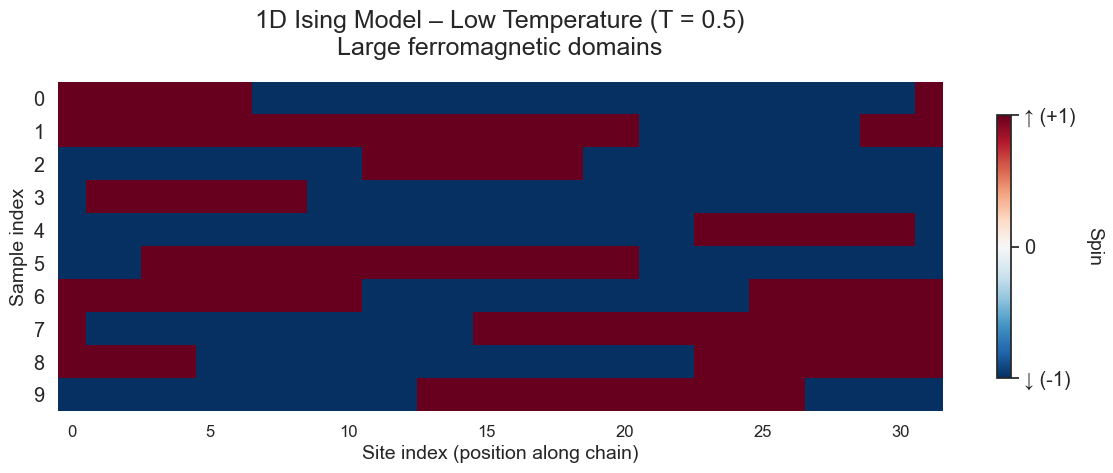

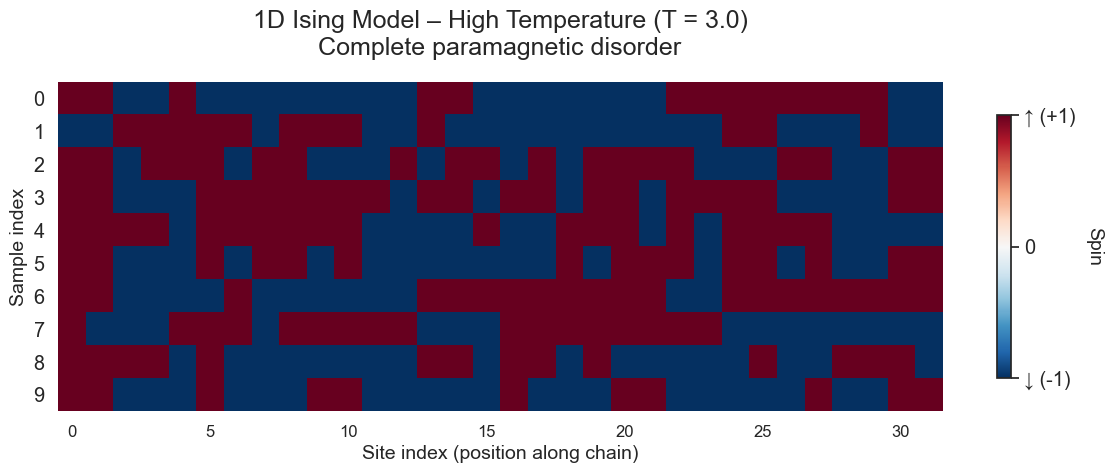

In [5]:
# Plot
plot_chains(low_T,  "1D Ising Model – Low Temperature (T = 0.5)\nLarge ferromagnetic domains")
plot_chains(high_T, "1D Ising Model – High Temperature (T = 3.0)\nComplete paramagnetic disorder")

### 2. Transfer Matrix Method

Exact Analytical Solution of the 1D Ising Model

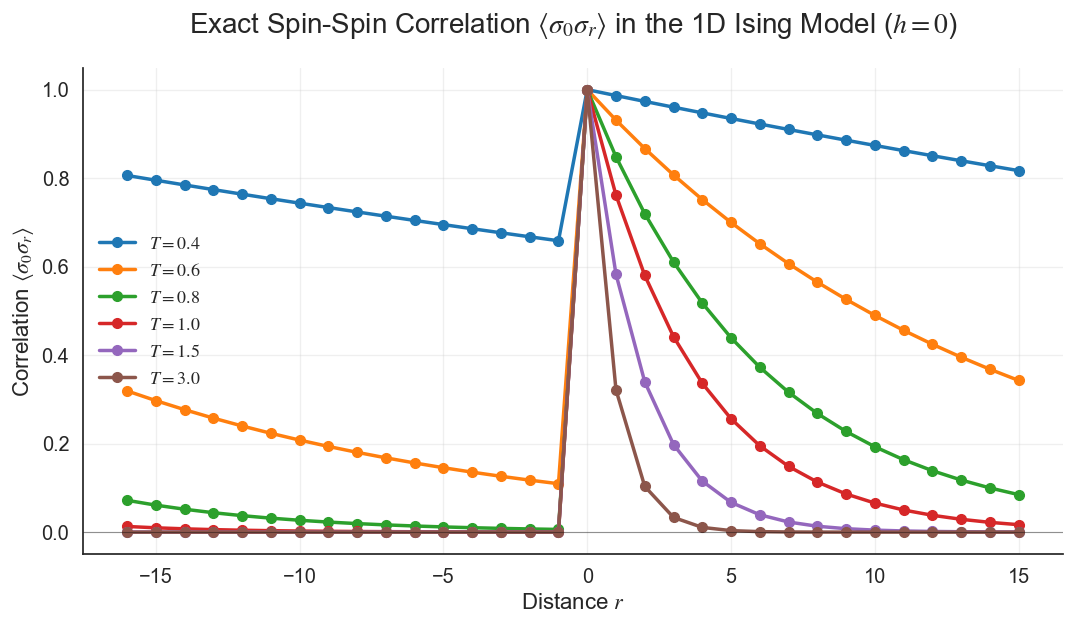

In [9]:
def exact_spin_correlation_1d(L: int = 32, temp: float = 1.0, J: float = 1.0) -> torch.Tensor:
    beta = 1.0 / temp
    corr = torch.tanh(torch.tensor(beta * J)) ** torch.arange(L)
    corr = torch.roll(corr, -L//2)
    return corr.cpu().numpy()

plt.figure(figsize=(11, 6.5))
temps = [0.4, 0.6, 0.8, 1.0, 1.5, 3.0]
colors = plt.cm.viridis(torch.linspace(0.9, 0.1, len(temps)))

for T in temps:
    corr = exact_spin_correlation_1d(temp=T)
    plt.plot(range(-16, 16), corr, 'o-', label=rf'$T = {T}$', markersize=7, lw=2.5)

plt.axhline(0, color='k', lw=0.8, alpha=0.4)
plt.title(r"Exact Spin-Spin Correlation $\langle \sigma_0 \sigma_r \rangle$"
          r" in the 1D Ising Model ($h=0$)", fontsize=20, pad=25)
plt.xlabel(r"Distance $r$", fontsize=16)
plt.ylabel(r"Correlation $\langle \sigma_0 \sigma_r \rangle$", fontsize=16)
plt.legend(fontsize=13, frameon=False)
plt.grid(True, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()